# Import Necessary Libraries

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import calendar

In [31]:
def evaluate_performance(y_true, y_pred):
    """
    Evaluate  model performance using MAE, MSE, RMSE, and R-squared.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        True target values.
    y_pred : array-like of shape (n_samples,)
        Predicted target values.
    
    Returns:
    mae : float
        Mean Absolute Error.
    mse : float
        Mean Squared Error.
    rmse : float
        Root Mean Squared Error.
    r_squared : float
        R-squared score.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_true, y_pred)
    
    return mae, mse, rmse, r_squared


# Import the Clean Dataset

In [10]:
# Import the CSV file as a DataFrame named df
df = pd.read_csv('dataset.csv')

print("DataFrame imported from dataset.csv")

DataFrame imported from dataset.csv


# Establishing a Basline

In [11]:
# Convert the 'datetime_copy' column to datetime format
df['datetime'] = df['datetime_copy'] # Retain as Duplicate column
df['datetime_copy'] = pd.to_datetime(df['datetime_copy'])

# Set the 'datetime_copy' column as the index
df.set_index('datetime_copy', inplace=True)

# Downsample to monthly recordings
df_monthly = df[['solarenergyMW', 'windenergyMW']].resample('M').mean().ffill()  # one value per month

# Resample and fill missing values for max wind, max temp, and max precip
df_monthly[['solarenergyMW_max', 'windenergyMW_max']] = df[['solarenergyMW', 'windenergyMW']].resample('M').max().ffill()

# Resample and fill missing values for min temp and min precip
df_monthly[['solarenergyMW_min', 'windenergyMW_min']] = df[['solarenergyMW', 'windenergyMW']].resample('M').min().ffill()


In [12]:
# Split the dataset
train = df_monthly[:'2019']  # all data until 2019 (included)
validation = df_monthly.loc['2020':'2021'] # all data for 2020
test = df_monthly.loc['2022':]  # all data for 2021
print('Start and end of training set:\t\t', train.index.min(), train.index.max())
print('Start and end of validation set:\t', validation.index.min(), validation.index.max())
print('Start and end of test set:\t\t', test.index.min(), test.index.max())

Start and end of training set:		 2010-01-31 00:00:00 2019-12-31 00:00:00
Start and end of validation set:	 2020-01-31 00:00:00 2021-12-31 00:00:00
Start and end of test set:		 2022-01-31 00:00:00 2024-01-31 00:00:00


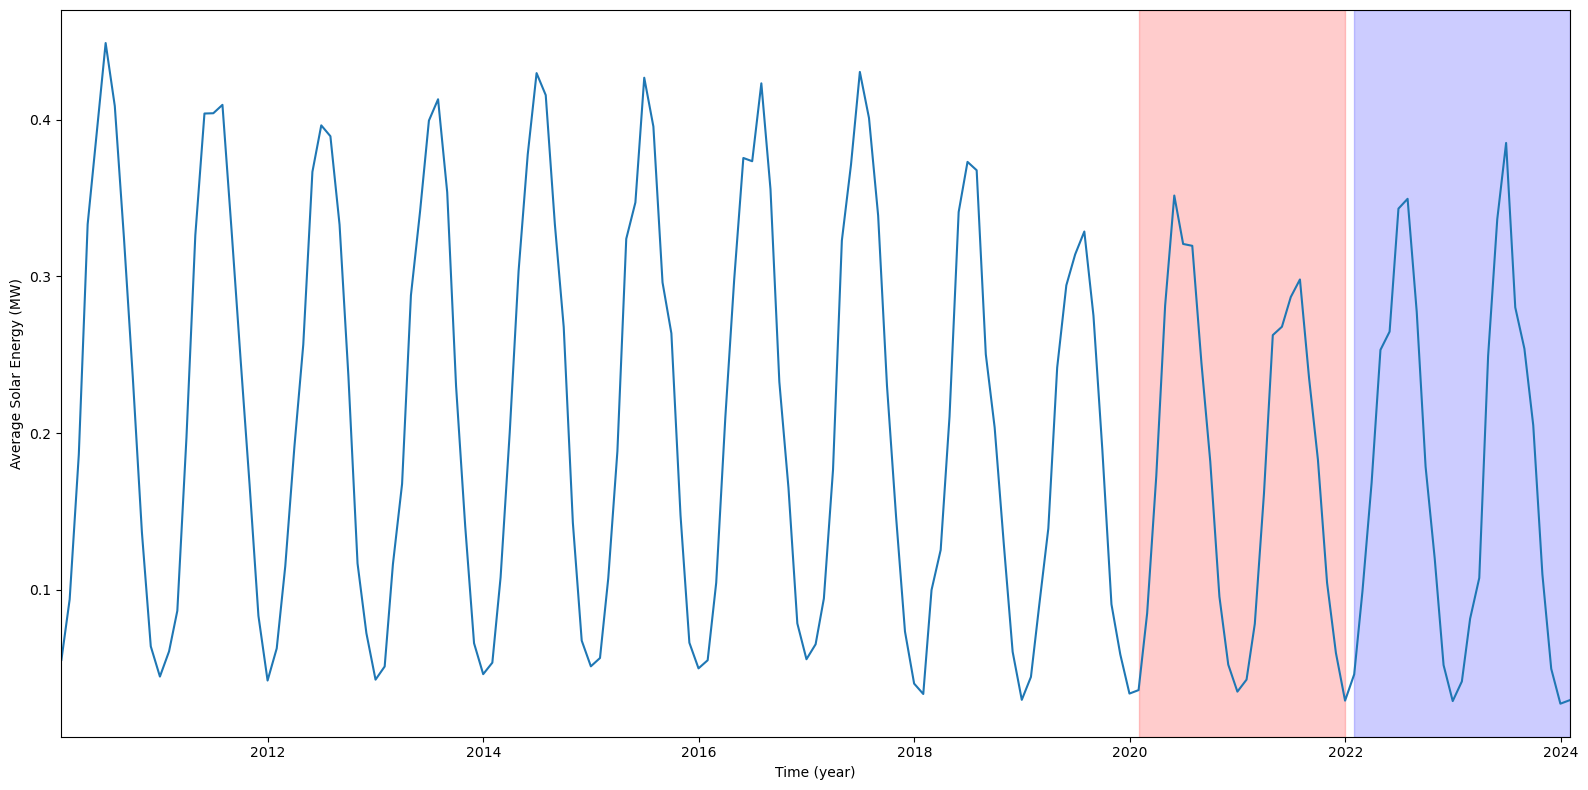

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_monthly.index, df_monthly['solarenergyMW'])
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Average Solar Energy (MW)')
_=ax.set_xlim(train.index.min(), test.index.max())
plt.tight_layout()

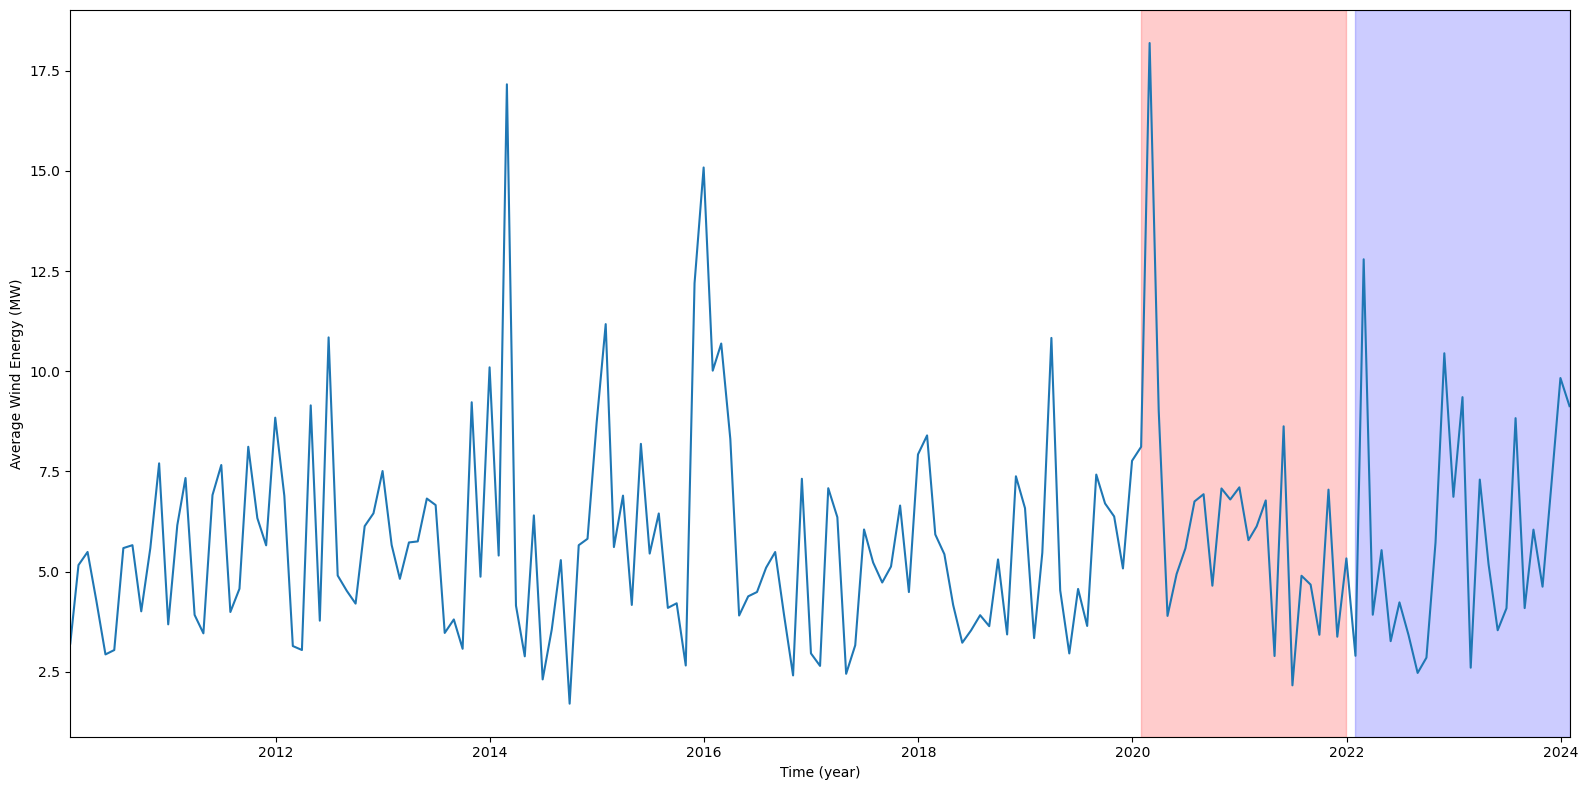

In [14]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_monthly.index, df_monthly['windenergyMW'])
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Average Wind Energy (MW)')
_=ax.set_xlim(train.index.min(), test.index.max())
plt.tight_layout()

C:\Users\sheik\AppData\Local\Temp\ipykernel_23184\836923917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.loc[:, 'baseline_last_period'] = train.loc['2018':'2020', 'solarenergyMW'].values


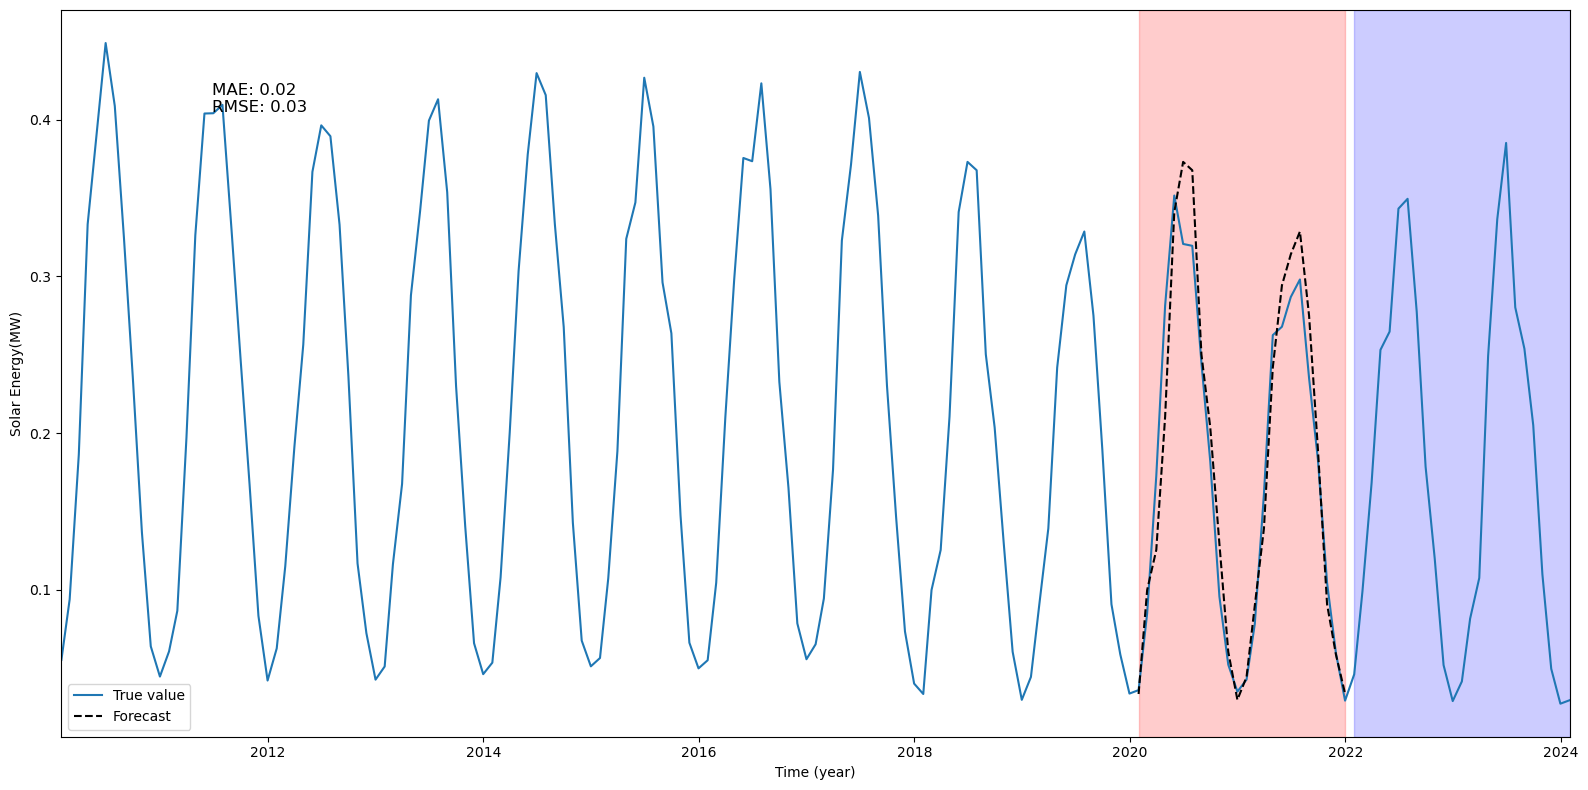

In [15]:
warnings.simplefilter(action='ignore', category=FutureWarning)
validation.loc[:, 'baseline_last_period'] = train.loc['2018':'2020', 'solarenergyMW'].values

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_monthly.index, df_monthly['solarenergyMW'], label='True value')
ax.plot(validation.index, validation['baseline_last_period'], '--', color='k', label='Forecast')
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Solar Energy(MW)')
_=ax.set_xlim(train.index.min(), test.index.max())
plt.legend(loc='best')

# Calculate and add error metrics
mae = mean_absolute_error(validation['solarenergyMW'], validation['baseline_last_period'])
rmse = mean_squared_error(validation['solarenergyMW'], validation['baseline_last_period'], squared=False)
ax.text(0.1, 0.9, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('./baseline_periodicity_solar.pdf', dpi=1000)


C:\Users\sheik\AppData\Local\Temp\ipykernel_23184\605130484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['baseline_last_period'] = train.loc['2018':'2020']['windenergyMW'].values


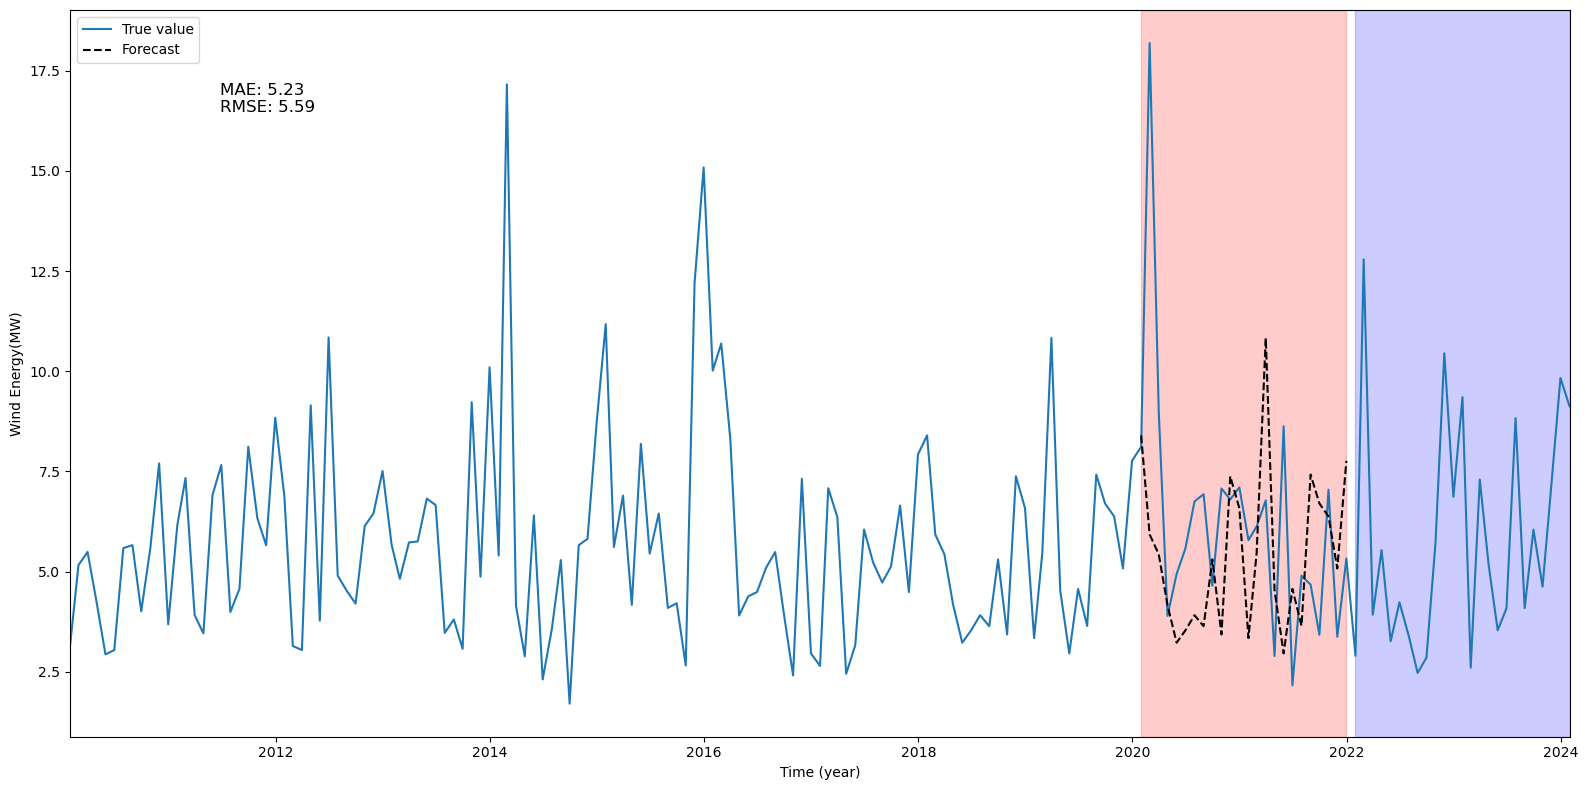

In [16]:
validation['baseline_last_period'] = train.loc['2018':'2020']['windenergyMW'].values
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_monthly.index, df_monthly['windenergyMW'], label='True value')
ax.plot(validation.index, validation['baseline_last_period'], '--', color='k', label='Forecast')
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Wind Energy(MW)')
_=ax.set_xlim(train.index.min(), test.index.max())
plt.legend(loc='best')

# Calculate and add error metrics
mae = mean_absolute_error(validation['solarenergyMW'], validation['baseline_last_period'])
rmse = mean_squared_error(validation['solarenergyMW'], validation['baseline_last_period'], squared=False)
ax.text(0.1, 0.9, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('./baseline_periodicity_wind.pdf', dpi=1000)


# Split the Dataset

In [17]:
# Split the dataset
train_df = df[:'2019']  # all data until 2019 (included)
validation_df = df.loc['2020':'2021'] # all data for 2020 to 2021
test_df = df.loc['2022':]  # all data for 2022 to end

Let us split the train data from 2010 to 2019, the validation set from 2020 to 2021 and the test set from 2022 to 2024

 # RNN Modelling Solar Energy

In [21]:
# Define features and target variable
features = ['temp', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth',
            'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'uvindex']
target = ['solarenergyMW']

# Split data into features and target for training and validation sets
X_train = train_df[features].values
y_train = train_df[target].values

X_val = validation_df[features].values
y_val = validation_df[target].values

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define sequence length (e.g., 24 hours)
sequence_length = 24

# Reshape data into sequences for training set
X_train_sequence = []
y_train_sequence = []
for i in range(len(X_train_scaled) - sequence_length):
    X_train_sequence.append(X_train_scaled[i:i+sequence_length])
    y_train_sequence.append(y_train[i+sequence_length])

X_train_sequence = np.array(X_train_sequence)
y_train_sequence = np.array(y_train_sequence)

# Reshape data into sequences for validation set
X_val_sequence = []
y_val_sequence = []
for i in range(len(X_val_scaled) - sequence_length):
    X_val_sequence.append(X_val_scaled[i:i+sequence_length])
    y_val_sequence.append(y_val[i+sequence_length])

X_val_sequence = np.array(X_val_sequence)
y_val_sequence = np.array(y_val_sequence)


In [22]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Define the model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(features))),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 50)            12800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33051 (129.11 KB)
Trainable params: 33051 (129.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Check shapes of training and validation sets
print("X_train shape:", X_train_sequence.shape)
print("y_train shape:", y_train_sequence.shape)
print("X_val shape:", X_val_sequence.shape)
print("y_val shape:", y_val_sequence.shape)

# Print out some sample sequences and corresponding target values
print("Sample X_train sequence:")
print(X_train_sequence[0])
print("Corresponding y_train value:", y_train_sequence[0])

# Check feature scaling
print("Min and Max values of original features:")
print(train_df[features].min())
print(train_df[features].max())
print("Min and Max values of scaled features:")
print(np.min(X_train_scaled, axis=0))
print(np.max(X_train_scaled, axis=0))

# Check the length of the index of the validation DataFrame
print("Length of validation DataFrame index:", len(validation_df.index))

# Check the length of the predicted values
predicted_values = model.predict(X_val_sequence).flatten()
print("Length of predicted values:", len(predicted_values))

X_train shape: (87576, 24, 13)
y_train shape: (87576, 1)
X_val shape: (17520, 24, 13)
y_val shape: (17520, 1)
Sample X_train sequence:
[[0.24       0.3490566  0.90708432 0.         0.         0.
  0.         0.08579882 0.7884776  0.67341772 0.844      0.
  0.        ]
 [0.2275     0.33018868 0.89399947 0.         0.         0.
  0.         0.14201183 0.92763707 0.6721519  0.712      0.
  0.        ]
 [0.2125     0.32075472 0.93193233 0.         0.         0.
  0.         0.06508876 0.88867242 0.67848101 0.9        0.
  0.        ]
 [0.195      0.3081761  0.94832144 0.         0.         0.
  0.         0.03698225 0.8942388  0.68481013 0.443      0.
  0.        ]
 [0.225      0.35220126 0.96708961 0.         0.         0.
  0.         0.08284024 1.         0.68860759 0.631      0.
  0.        ]
 [0.2425     0.36477987 0.9444885  0.         0.         0.
  0.         0.19822485 0.03979961 0.69113924 0.748      0.
  0.        ]
 [0.24       0.35534591 0.92598467 0.00123514 1.         0.
 

In [24]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_sequence, y_train_sequence, epochs=50, batch_size=32, validation_data=(X_val_sequence, y_val_sequence), callbacks=[early_stopping])


Epoch 1/50

2737/2737 [==============================] - 34s 11ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 2/50
2737/2737 [==============================] - 32s 12ms/step - loss: 0.0044 - val_loss: 0.0085
Epoch 3/50
2737/2737 [==============================] - 32s 12ms/step - loss: 0.0040 - val_loss: 0.0083
Epoch 4/50
2737/2737 [==============================] - 32s 12ms/step - loss: 0.0038 - val_loss: 0.0082
Epoch 5/50
2737/2737 [==============================] - 30s 11ms/step - loss: 0.0037 - val_loss: 0.0086
Epoch 6/50
2737/2737 [==============================] - 30s 11ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 7/50
2737/2737 [==============================] - 30s 11ms/step - loss: 0.0035 - val_loss: 0.0082
Epoch 8/50
2737/2737 [==============================] - 30s 11ms/step - loss: 0.0035 - val_loss: 0.0083
Epoch 9/50
2737/2737 [==============================] - 30s 11ms/step - loss: 0.0035 - val_loss: 0.0080
Epoch 10/50
2737/2737 [==============================] - 30s 11

In [25]:
# Evaluate the model on the validation data
loss = model.evaluate(X_val_sequence, y_val_sequence)

print("Validation Loss:", loss)

548/548 [==============================] - 2s 4ms/step - loss: 0.0077
Validation Loss: 0.007726120762526989


A lower validation loss generally indicates better performance, suggesting that the model's predictions are closer to the actual values.

In [27]:
# Predict solar energy values using the model
y_pred_val = model.predict(X_val_sequence)

# Flatten y_val_sequence and y_pred_val arrays
y_val_flat = y_val_sequence.flatten()
y_pred_val_flat = y_pred_val.flatten()


548/548 [==============================] - 3s 4ms/step


In [28]:
# Export the predicted solar energy values for the validation set to a CSV file
validation_datetime_index = validation_df.index[sequence_length:]
predicted_df_valid = pd.DataFrame({
    'datetime': validation_datetime_index,
    'temp': validation_df['temp'].values[sequence_length:],
    'dew': validation_df['dew'].values[sequence_length:],
    'humidity': validation_df['humidity'].values[sequence_length:],
    'precip': validation_df['precip'].values[sequence_length:],
    'precipprob': validation_df['precipprob'].values[sequence_length:],
    'snow': validation_df['snow'].values[sequence_length:],
    'snowdepth': validation_df['snowdepth'].values[sequence_length:],
    'windspeed': validation_df['windspeed'].values[sequence_length:],
    'winddir': validation_df['winddir'].values[sequence_length:],
    'sealevelpressure': validation_df['sealevelpressure'].values[sequence_length:],
    'cloudcover': validation_df['cloudcover'].values[sequence_length:],
    'solarradiation': validation_df['solarradiation'].values[sequence_length:],
    'uvindex': validation_df['uvindex'].values[sequence_length:],
    'year': validation_df['year'].values[sequence_length:],
    'windspeed_ms': validation_df['windspeed_ms'].values[sequence_length:],
    'windenergyMW': validation_df['windenergyMW'].values[sequence_length:],
    'solarenergyMW': validation_df['solarenergyMW'].values[sequence_length:],
    'month': validation_df['month'].values[sequence_length:],
    'predicted_solar_energy': y_pred_val_flat
})
predicted_df_valid.to_csv('validation_predicted.csv', index=False)
print("All features along with predicted solar energy for the validation set exported to validation_predicted.csv")


All features along with predicted solar energy for the validation set exported to validation_predicted.csv


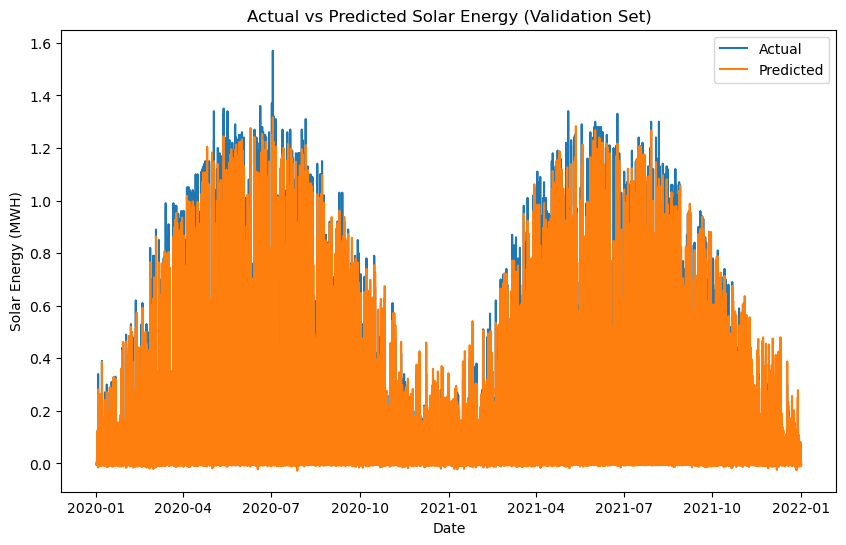

In [30]:
# Plot actual vs predicted values for solar energy
plt.figure(figsize=(10, 6))

plt.plot(predicted_df_valid['datetime'], predicted_df_valid['solarenergyMW'], label='Actual')
plt.plot(predicted_df_valid['datetime'], predicted_df_valid['predicted_solar_energy'], label='Predicted')

plt.xlabel('Date')
plt.ylabel('Solar Energy (MWH)')
plt.title('Actual vs Predicted Solar Energy (Validation Set)')
plt.legend()
plt.show()

In [32]:
mae, mse, rmse, r_squared = evaluate_performance(y_val_flat, y_pred_val_flat)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²) Score:", r_squared)

Mean Absolute Error (MAE): 0.04315511330176298
Mean Squared Error (MSE): 0.00772612195337029
Root Mean Squared Error (RMSE): 0.08789836149422973
R-squared (R²) Score: 0.9129100754301158


We have low error metrics (MAE, MSE, and RMSE) and a high R-squared score, indicating that it accurately captures the relationship between the features and the target variable.

# Solar Energy Test Set

In [35]:
# Split data into features and target for test set
X_test = test_df[features].values
y_test = test_df[target].values

# Normalize features using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)

# Reshape data into sequences for test set
X_test_sequence = []
y_test_sequence = []
for i in range(len(X_test_scaled) - sequence_length):
    X_test_sequence.append(X_test_scaled[i:i+sequence_length])
    y_test_sequence.append(y_test[i+sequence_length])

X_test_sequence = np.array(X_test_sequence)
y_test_sequence = np.array(y_test_sequence)

# Predict solar energy values using the model for test set
y_pred_test = model.predict(X_test_sequence)

# Flatten y_test_sequence and y_pred_test arrays
y_test_flat = y_test_sequence.flatten()
y_pred_test_flat = y_pred_test.flatten()

# Export the predicted solar energy values for the test set to a CSV file
test_datetime_index = test_df.index[sequence_length:]
predicted_df_test = pd.DataFrame({
    'datetime': test_datetime_index,
    'temp': test_df['temp'].values[sequence_length:],
    'dew': test_df['dew'].values[sequence_length:],
    'humidity': test_df['humidity'].values[sequence_length:],
    'precip': test_df['precip'].values[sequence_length:],
    'precipprob': test_df['precipprob'].values[sequence_length:],
    'snow': test_df['snow'].values[sequence_length:],
    'snowdepth': test_df['snowdepth'].values[sequence_length:],
    'windspeed': test_df['windspeed'].values[sequence_length:],
    'winddir': test_df['winddir'].values[sequence_length:],
    'sealevelpressure': test_df['sealevelpressure'].values[sequence_length:],
    'cloudcover': test_df['cloudcover'].values[sequence_length:],
    'solarradiation': test_df['solarradiation'].values[sequence_length:],
    'uvindex': test_df['uvindex'].values[sequence_length:],
    'year': test_df['year'].values[sequence_length:],
    'windspeed_ms': test_df['windspeed_ms'].values[sequence_length:],
    'windenergyMW': test_df['windenergyMW'].values[sequence_length:],
    'solarenergyMW': test_df['solarenergyMW'].values[sequence_length:],
    'month': test_df['month'].values[sequence_length:],
    'predicted_solar_energy': y_pred_test_flat,
})
predicted_df_test.to_csv('test_predicted.csv', index=False)
print("All features along with predicted solar energy for the test set exported to test_predicted.csv")


551/551 [==============================] - 14s 24ms/step
All features along with predicted solar energy for the test set exported to test_predicted.csv


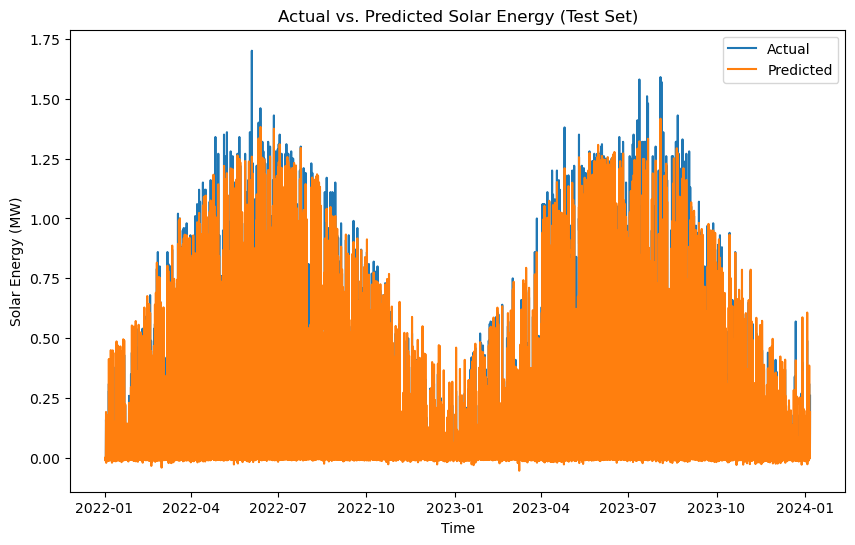

<Figure size 640x480 with 0 Axes>

In [36]:
# Plot actual vs. predicted solar energy values for the test set
plt.figure(figsize=(10, 6))
plt.plot(predicted_df_test['datetime'], predicted_df_test['solarenergyMW'], label='Actual')
plt.plot(predicted_df_test['datetime'], predicted_df_test['predicted_solar_energy'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Solar Energy (MW)')
plt.title('Actual vs. Predicted Solar Energy (Test Set)')
plt.legend()
plt.show()
# Save the figure
plt.savefig('solar_test.png', bbox_inches='tight', dpi=300)
plt.show()

In [38]:
mae, mse, rmse, r_squared = evaluate_performance(y_test_flat, y_pred_test_flat)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²) Score:", r_squared)

Mean Absolute Error (MAE): 0.04891217452525714
Mean Squared Error (MSE): 0.010521623344976489
Root Mean Squared Error (RMSE): 0.10257496451364967
R-squared (R²) Score: 0.8863160345116703


We have low error metrics (MAE, MSE, and RMSE) and a high R-squared score, indicating that it accurately captures the relationship between the features and the target variable in the test set as well.

# RNN Modelling for Wind Energy

In [39]:
# Define features and target variable
features = ['temp', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth',
            'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'uvindex']
target = ['windenergyMW']

# Split data into features and target for training and validation sets
X_train = train_df[features].values
y_train = train_df[target].values

X_val = validation_df[features].values
y_val = validation_df[target].values

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define sequence length (e.g., 24 hours)
sequence_length = 24

# Reshape data into sequences for training set
X_train_sequence = []
y_train_sequence = []
for i in range(len(X_train_scaled) - sequence_length):
    X_train_sequence.append(X_train_scaled[i:i+sequence_length])
    y_train_sequence.append(y_train[i+sequence_length])

X_train_sequence = np.array(X_train_sequence)
y_train_sequence = np.array(y_train_sequence)

# Reshape data into sequences for validation set
X_val_sequence = []
y_val_sequence = []
for i in range(len(X_val_scaled) - sequence_length):
    X_val_sequence.append(X_val_scaled[i:i+sequence_length])
    y_val_sequence.append(y_val[i+sequence_length])

X_val_sequence = np.array(X_val_sequence)
y_val_sequence = np.array(y_val_sequence)

In [40]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
# Define the model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(features))),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24, 50)            12800     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33051 (129.11 KB)
Trainable params: 33051 (129.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_sequence, y_train_sequence, epochs=50, batch_size=32, validation_data=(X_val_sequence, y_val_sequence), callbacks=[early_stopping])

Epoch 1/50
2737/2737 [==============================] - 84s 28ms/step - loss: 42.0166 - val_loss: 29.1934
Epoch 2/50
2737/2737 [==============================] - 64s 24ms/step - loss: 21.7695 - val_loss: 23.4704
Epoch 3/50
2737/2737 [==============================] - 53s 19ms/step - loss: 19.4524 - val_loss: 25.3283
Epoch 4/50
2737/2737 [==============================] - 67s 24ms/step - loss: 18.6181 - val_loss: 21.2181
Epoch 5/50
2737/2737 [==============================] - 67s 24ms/step - loss: 18.0041 - val_loss: 21.6976
Epoch 6/50
2737/2737 [==============================] - 78s 29ms/step - loss: 17.6406 - val_loss: 20.4203
Epoch 7/50
2737/2737 [==============================] - 43s 16ms/step - loss: 17.2767 - val_loss: 20.4662
Epoch 8/50
2737/2737 [==============================] - 47s 17ms/step - loss: 17.1305 - val_loss: 20.8157
Epoch 9/50
2737/2737 [==============================] - 45s 17ms/step - loss: 17.0068 - val_loss: 21.8302
Epoch 10/50
2737/2737 [=======================

In [42]:
# Evaluate the model on the validation data
loss = model.evaluate(X_val_sequence, y_val_sequence)

print("Validation Loss:", loss)

548/548 [==============================] - 6s 10ms/step - loss: 20.6657
Validation Loss: 20.66571617126465


In [43]:
# Predict solar energy values using the model
y_pred_val = model.predict(X_val_sequence)

# Flatten y_val_sequence and y_pred_val arrays
y_val_flat = y_val_sequence.flatten()
y_pred_val_flat = y_pred_val.flatten()
predicted_df_valid['predicted_wind_energy'] = y_pred_val

548/548 [==============================] - 6s 9ms/step


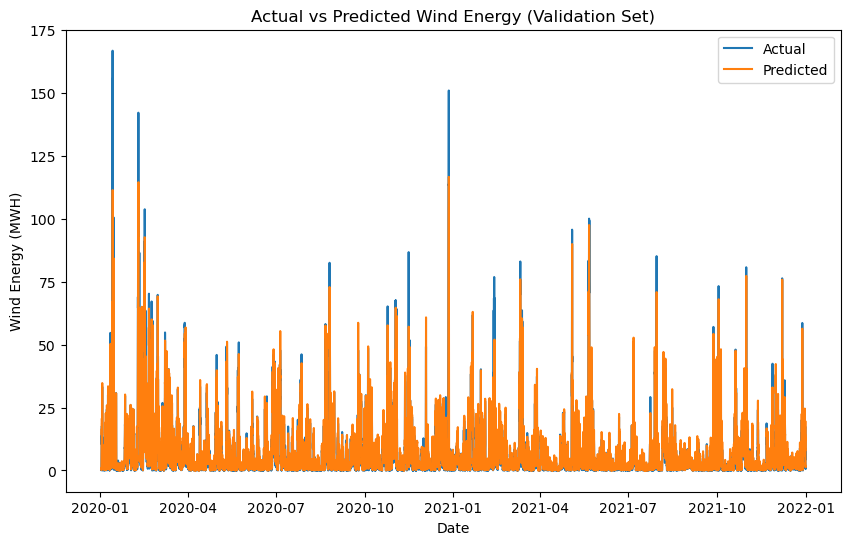

In [47]:
# Plot actual vs predicted values for solar energy
plt.figure(figsize=(10, 6))

plt.plot(predicted_df_valid['datetime'], predicted_df_valid['windenergyMW'], label='Actual')
plt.plot(predicted_df_valid['datetime'], predicted_df_valid['predicted_wind_energy'], label='Predicted')

plt.xlabel('Date')
plt.ylabel('Wind Energy (MWH)')
plt.title('Actual vs Predicted Wind Energy (Validation Set)')
plt.legend()
plt.show()

In [48]:
mae, mse, rmse, r_squared = evaluate_performance(y_val_flat, y_pred_val_flat)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²) Score:", r_squared)

Mean Absolute Error (MAE): 2.215037575223947
Mean Squared Error (MSE): 20.66570663879363
Root Mean Squared Error (RMSE): 4.545954975447253
R-squared (R²) Score: 0.8220264811755074


# Wind Energy Test Set

In [49]:
# Split data into features and target for test set
X_test = test_df[features].values
y_test = test_df[target].values

# Normalize features using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)

# Reshape data into sequences for test set
X_test_sequence = []
y_test_sequence = []
for i in range(len(X_test_scaled) - sequence_length):
    X_test_sequence.append(X_test_scaled[i:i+sequence_length])
    y_test_sequence.append(y_test[i+sequence_length])

X_test_sequence = np.array(X_test_sequence)
y_test_sequence = np.array(y_test_sequence)

# Predict solar energy values using the model for test set
y_pred_test = model.predict(X_test_sequence)

# Flatten y_test_sequence and y_pred_test arrays
y_test_flat = y_test_sequence.flatten()
y_pred_test_flat = y_pred_test.flatten()

predicted_df_test['predicted_wind_energy'] = y_pred_test

551/551 [==============================] - 6s 12ms/step


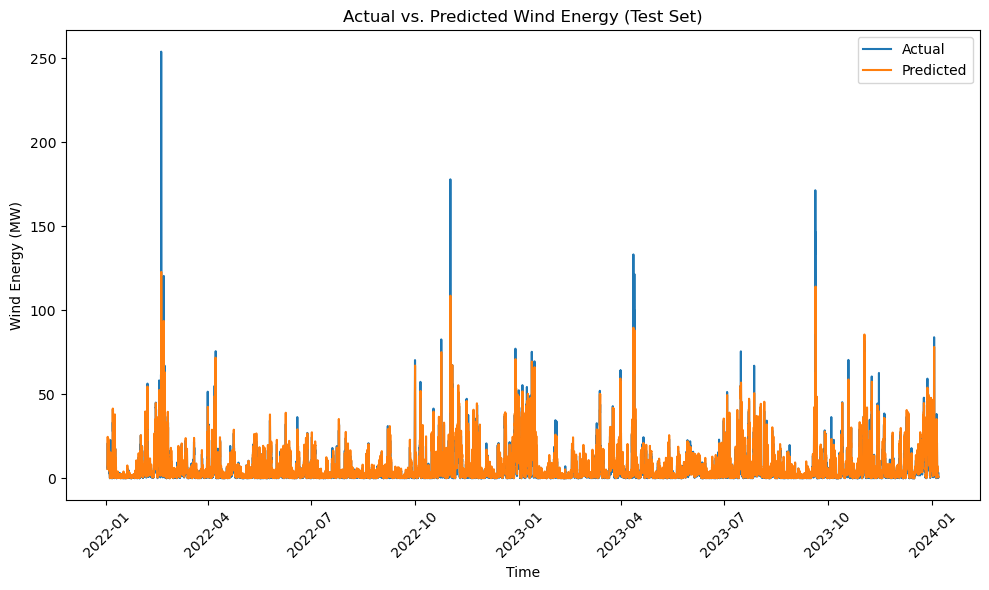

<Figure size 640x480 with 0 Axes>

In [51]:
# Plot actual vs. predicted wind energy values for the test set
plt.figure(figsize=(10, 6))
plt.plot(predicted_df_test['datetime'], predicted_df_test['windenergyMW'], label='Actual')
plt.plot(predicted_df_test['datetime'], predicted_df_test['predicted_wind_energy'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Wind Energy (MW)')
plt.title('Actual vs. Predicted Wind Energy (Test Set)')
plt.legend()

# Format the x-axis to display time
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
# Save the figure
plt.savefig('wind_test.png', bbox_inches='tight', dpi=300)
plt.show()

In [52]:
mae, mse, rmse, r_squared = evaluate_performance(y_test_flat, y_pred_test_flat)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²) Score:", r_squared)

Mean Absolute Error (MAE): 2.2576523735194836
Mean Squared Error (MSE): 22.421365654575897
Root Mean Squared Error (RMSE): 4.735120447736879
R-squared (R²) Score: 0.7901597194165035


# Total Energy Analysis

In [53]:
# Calculate total energy (sum of wind and solar energy) for each row
predicted_df_test['total_energy_predicted'] = predicted_df_test['predicted_wind_energy'] + predicted_df_test['predicted_solar_energy']
predicted_df_test['total_energy'] = predicted_df_test['windenergyMW'] + predicted_df_test['solarenergyMW']
threshold =95

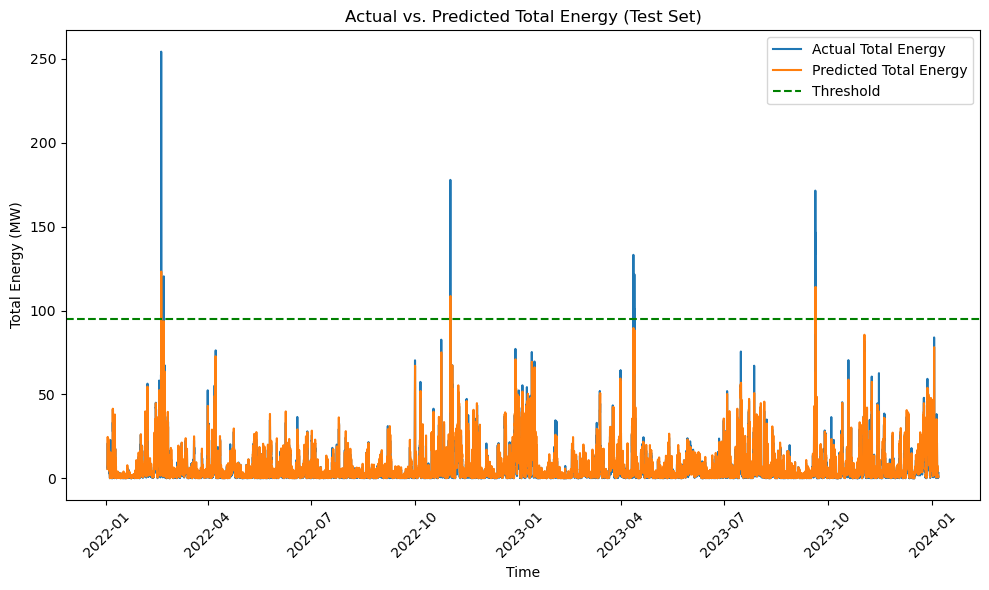

<Figure size 640x480 with 0 Axes>

In [63]:
# Plot actual vs. predicted wind energy values for the test set
plt.figure(figsize=(10, 6))
plt.plot(predicted_df_test['datetime'], predicted_df_test['total_energy'], label='Actual Total Energy')
plt.plot(predicted_df_test['datetime'], predicted_df_test['total_energy_predicted'], label='Predicted Total Energy')
plt.xlabel('Time')
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')
plt.ylabel('Total Energy (MW)')
plt.title('Actual vs. Predicted Total Energy (Test Set)')
plt.legend()

# Format the x-axis to display time
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
# Save the figure
plt.savefig('TE_test.png', bbox_inches='tight', dpi=300)
plt.show()

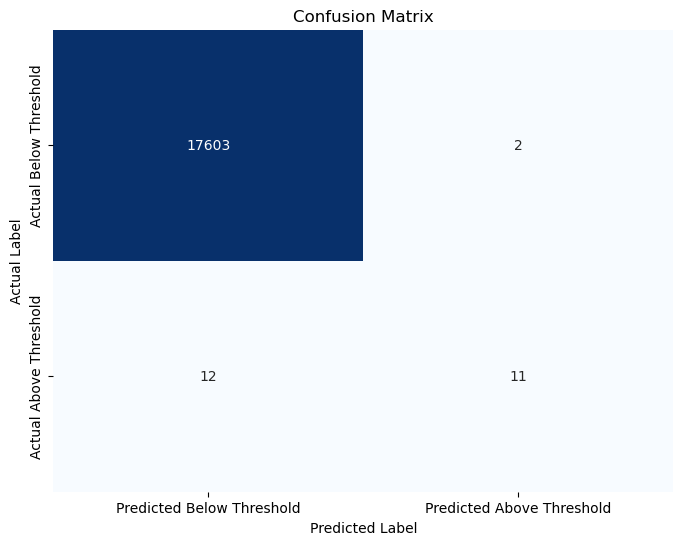

<Figure size 640x480 with 0 Axes>

In [64]:
# Create binary labels indicating whether the predicted total energy is above the threshold
predicted_labels = (predicted_df_test['total_energy_predicted'] > threshold).astype(int)

# Create binary labels indicating whether the actual total energy is above the threshold
actual_labels = (predicted_df_test['total_energy'] > threshold).astype(int)

# Create a confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted Below Threshold', 'Predicted Above Threshold'],
            yticklabels=['Actual Below Threshold', 'Actual Above Threshold'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
# Save the figure
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

We have 2 false postives which means the company will incur a loss for these 2 hours. Let us Analyse these rows.

In [65]:
# Identify rows where predicted total energy is above the threshold
above_threshold_rows = predicted_df_test[predicted_df_test['total_energy_predicted'] > threshold]

# Export the above threshold rows to an Excel sheet
above_threshold_rows.to_excel('above_threshold_predictions.xlsx', index=False)

print("Rows where predicted total energy is above threshold exported to above_threshold_predictions.xlsx")

Rows where predicted total energy is above threshold exported to above_threshold_predictions.xlsx


In [66]:
# Identify rows where predicted total energy is above the threshold but actual total energy is below
false_positive_rows = predicted_df_test[(predicted_df_test['total_energy_predicted'] > threshold) & (predicted_df_test['total_energy'] < threshold)].copy()

# Calculate the difference between predicted and actual total energy
false_positive_rows['difference'] = false_positive_rows['total_energy_predicted'] - false_positive_rows['total_energy']

# Multiply each difference by 50 and add it to a new column named 'ascost'
false_positive_rows['cost'] = false_positive_rows['difference'].apply(lambda x: x * 50)

# Export the DataFrame to an Excel sheet with the updated 'ascost' column
false_positive_rows.to_excel('false_positive_predictions_with_ascost.xlsx', index=False)

print("Rows exported to false_positive_predictions_with_ascost.xlsx with cost calculated")

Rows exported to false_positive_predictions_with_ascost.xlsx with cost calculated


In [67]:
# Read the exported Excel sheet
false_positive_data = pd.read_excel('false_positive_predictions_with_ascost.xlsx')

# Calculate the sum of all cost elements
total_cost = false_positive_data['cost'].sum()

print("Total cost:", total_cost)

Total cost: 4325.914398193359


The company will incur a loss of 4325.91 GBP

In [68]:
# Initialize a list to store R2 scores
r2_scores = []

# Iterate over each month (from 1 to 12)
for month in range(1, 13):
    # Filter predicted_df_test for the current month
    month_data = predicted_df_test[predicted_df_test['datetime'].dt.month == month]
    
    # Calculate R2 score for the filtered data
    r2 = r2_score(month_data['total_energy'], month_data['total_energy_predicted'])
    
    # Append month and R2 score to the list
    r2_scores.append((month, r2))

# Convert the list of tuples to a DataFrame
r2_df = pd.DataFrame(r2_scores, columns=['Month', 'R2 Score'])

# Display the calculated R2 scores
print("R2 score for each month's data on the predicted_df_test:")
print(r2_df)


R2 score for each month's data on the predicted_df_test:
    Month  R2 Score
0       1  0.837351
1       2  0.797518
2       3  0.821297
3       4  0.750850
4       5  0.751985
5       6  0.645113
6       7  0.821728
7       8  0.692855
8       9  0.835212
9      10  0.682376
10     11  0.743444
11     12  0.783568


These scores indicate the goodness of fit of the predictions compared to the actual total energy values for each respective month. R2 scores closer to 1 indicate better performance of the model in explaining the variability of the data.

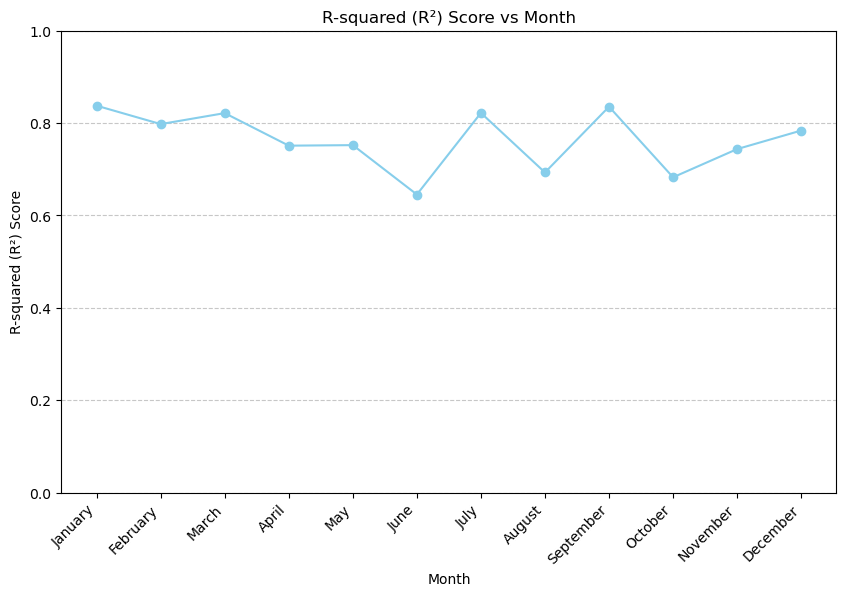

In [71]:
# Extracting month and R2 score from the DataFrame
months = r2_df['Month']
r2_scores = r2_df['R2 Score']

# Get month names
month_names = [calendar.month_name[month] for month in months]

# Plotting the R2 scores
plt.figure(figsize=(10, 6))
plt.plot(month_names, r2_scores, marker='o', color='skyblue', linestyle='-')
plt.title('R-squared (R²) Score vs Month')
plt.xlabel('Month')
plt.ylabel('R-squared (R²) Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim(0, 1)  # Setting y-axis limit from 0 to 1 for R2 score
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
